In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd
import os

In [3]:
!pip install --user mplhep

     |████████████████████████████████| 5.8 MB 8.2 MB/s eta 0:00:01


In [11]:
import mplhep as hep
plt.style.use(hep.style.CMS)

In [19]:
store_ele = pd.HDFStore("output_PU_clusters_check_ele_v7.h5")
# store_ele2 = pd.HDFStore("output_PU_clusters_check_ele_v7.h5")
# dfele = pd.concat([store_ele['df'], store_ele2['df']])
df =store_ele['df']
store_ele.close()
# store_ele2.close()
outputdir = "/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/validation_sim_truth/simfraction_electron"
os.makedirs(outputdir, exist_ok=True)

In [31]:
store_gam = pd.HDFStore("output_PU_clusters_check_gamma_v7.h5")
# store_gam2 = pd.HDFStore("output_PU_clusters_check_gamma_v6.2.h5")
# dfgamma = pd.concat([store_gam['df'], store_gam2['df']])
df = store_gam['df']
store_gam.close()
# store_gam2.close()
outputdir = "/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/validation_sim_truth/simfraction_gamma"
os.makedirs(outputdir, exist_ok=True)

# Resolution study

Let's study the best threshold for resolution

In [20]:
def bin_analysis(group):
    ratio_left = group["EoEtrue"].quantile(0.16)
    ratio_right = group["EoEtrue"].quantile(0.84)
    ratio_mean = group[(group.EoEtrue >= ratio_left) & (group.EoEtrue <= ratio_right) ].EoEtrue.mean()
    count = group["EoEtrue"].count()
    return pd.Series(  
        { 
             "quantile_down": ratio_left,
             "quantile_up": ratio_right,
             "EoEtrue_68scale": ratio_mean,
             "EoEtrue_68width": (ratio_right-ratio_left)/2, 
             #"EoEtrue_68width": abs(ratio_right- ratio_left), 
             "EoEtrue_scale":  group.EoEtrue.mean(),
             "EoEtrue_rms":  group.EoEtrue.std(),
             "rel_err" : 1/np.sqrt(count)
        })


In [32]:
seed = df[(df.is_seed==1)][['wi','en','eta','et', 'simfrac_sig']]
seed.columns = ['wi','seed_en','seed_eta','seed_et','seed_simfrac_sig']

dfa = df.join(seed.set_index("wi"), on='wi')

In [33]:
np.logspace(-4,-0.7, 40)

array([1.00000000e-04, 1.21510941e-04, 1.47649088e-04, 1.79409797e-04,
       2.18002532e-04, 2.64896929e-04, 3.21878751e-04, 3.91117900e-04,
       4.75251041e-04, 5.77482013e-04, 7.01703829e-04, 8.52646926e-04,
       1.03605930e-03, 1.25892541e-03, 1.52973212e-03, 1.85879189e-03,
       2.25863552e-03, 2.74448928e-03, 3.33485475e-03, 4.05221339e-03,
       4.92388263e-03, 5.98305613e-03, 7.27006781e-03, 8.83392781e-03,
       1.07341888e-02, 1.30432139e-02, 1.58489319e-02, 1.92581863e-02,
       2.34008035e-02, 2.84345365e-02, 3.45510729e-02, 4.19833339e-02,
       5.10143442e-02, 6.19880097e-02, 7.53222140e-02, 9.15247311e-02,
       1.11212562e-01, 1.35135431e-01, 1.64204334e-01, 1.99526231e-01])

In [34]:
# etas = [0,0.4,0.6,0.8,1.2,1.44, 1.57, 1.65, 1.75,2,2.25,2.5, 3]
etas = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.35, 1.44, 1.57, 1.75, 2.0 ,2.2,2.4,3.0]
# ets =  [0,2,4,6,8,10,20,30,40,50,60,80,100]
ets = [ 0,2,3,4,6,10,15,20,30,40,50,60,70,80,90,100]
# thres = [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.004, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08 ,0.09 ,0.1 ,
#          0.15 ,0.20 ,0.25 ,0.30 ,0.40 ,0.50, 0.60 ,0.70, 0.80]
thres = np.logspace(-4,-0.7, 40)
    
res= []
# res_all = []

dfb = dfa[(dfa.seed_simfrac_sig > 0.01) & (dfa.in_window)]

for thr in thres:
    #print("DNN threshold: ", thr)
    g = dfb[(dfb.simfrac_sig >  thr) | (dfb.is_seed==1) ].groupby("wi", sort=False).agg(
                        {
                         "en": 'sum' ,
                         "calo_simen_good": "first", 
                         "seed_et": "first",
                         "seed_eta": "first"
                            })
    g["EoEtrue"] = g["en"] / g["calo_simen_good"]
    g["thr"]= thr
    g["et_bin"] = pd.cut(g["seed_et"], ets, labels=list(range(len(ets)-1)))
    g["eta_bin"] = pd.cut(g["seed_eta"], etas, labels=list(range(len(etas)-1)))

    scanres = g.groupby(["et_bin","eta_bin"]).apply(bin_analysis)                   
    scanres["thr"] = thr
    res.append(scanres)



res = pd.concat(res)


In [35]:
res.reset_index(level=0, inplace=True)
res.reset_index(level=0, inplace=True)

In [36]:
res

eta_bin et_bin  quantile_down  quantile_up  EoEtrue_68scale  \
0          0      0       0.464840     0.890680         0.708935   
1          1      0       0.501219     0.873354         0.710869   
2          2      0       0.498667     0.878131         0.707095   
3          3      0       0.524079     0.895390         0.724548   
4          4      0       0.485476     0.895856         0.702972   
...      ...    ...            ...          ...              ...   
8395       9     14       0.997900     1.027160         1.012412   
8396      10     14       0.999494     1.027387         1.013397   
8397      11     14       0.999248     1.033365         1.016225   
8398      12     14       1.000128     1.038426         1.019337   
8399      13     14       0.984167     1.061651         1.022719   

      EoEtrue_68width  EoEtrue_scale  EoEtrue_rms   rel_err       thr  
0            0.212920       1.109916     9.689105  0.038069  0.000100  
1            0.186068       0.758289     1.125568  0.038125  0.000100  
2            0.189732       0.719596     0.425536  0.036491  0.000100  
3            0.185656       0.877545     3.449074  0.037372  0.000100  
4            0.205190       0.766494     0.922559  0.032292  0.000100  
...               ...            ...          ...       ...       ...  
8395         0.014630       1.040705     0.385243  0.027007  0.199526  
8396         0.013946       1.013438     0.014652  0.022228  0.199526  
8397         0.017059       1.016324     0.017173  0.022277  0.199526  
8398         0.019149       1.019593     0.020517  0.021843  0.199526  
8399         0.038742       1.024557     0.040355  0.015823  0.199526  

[8400 rows x 10 columns]

## By Et and eta bin

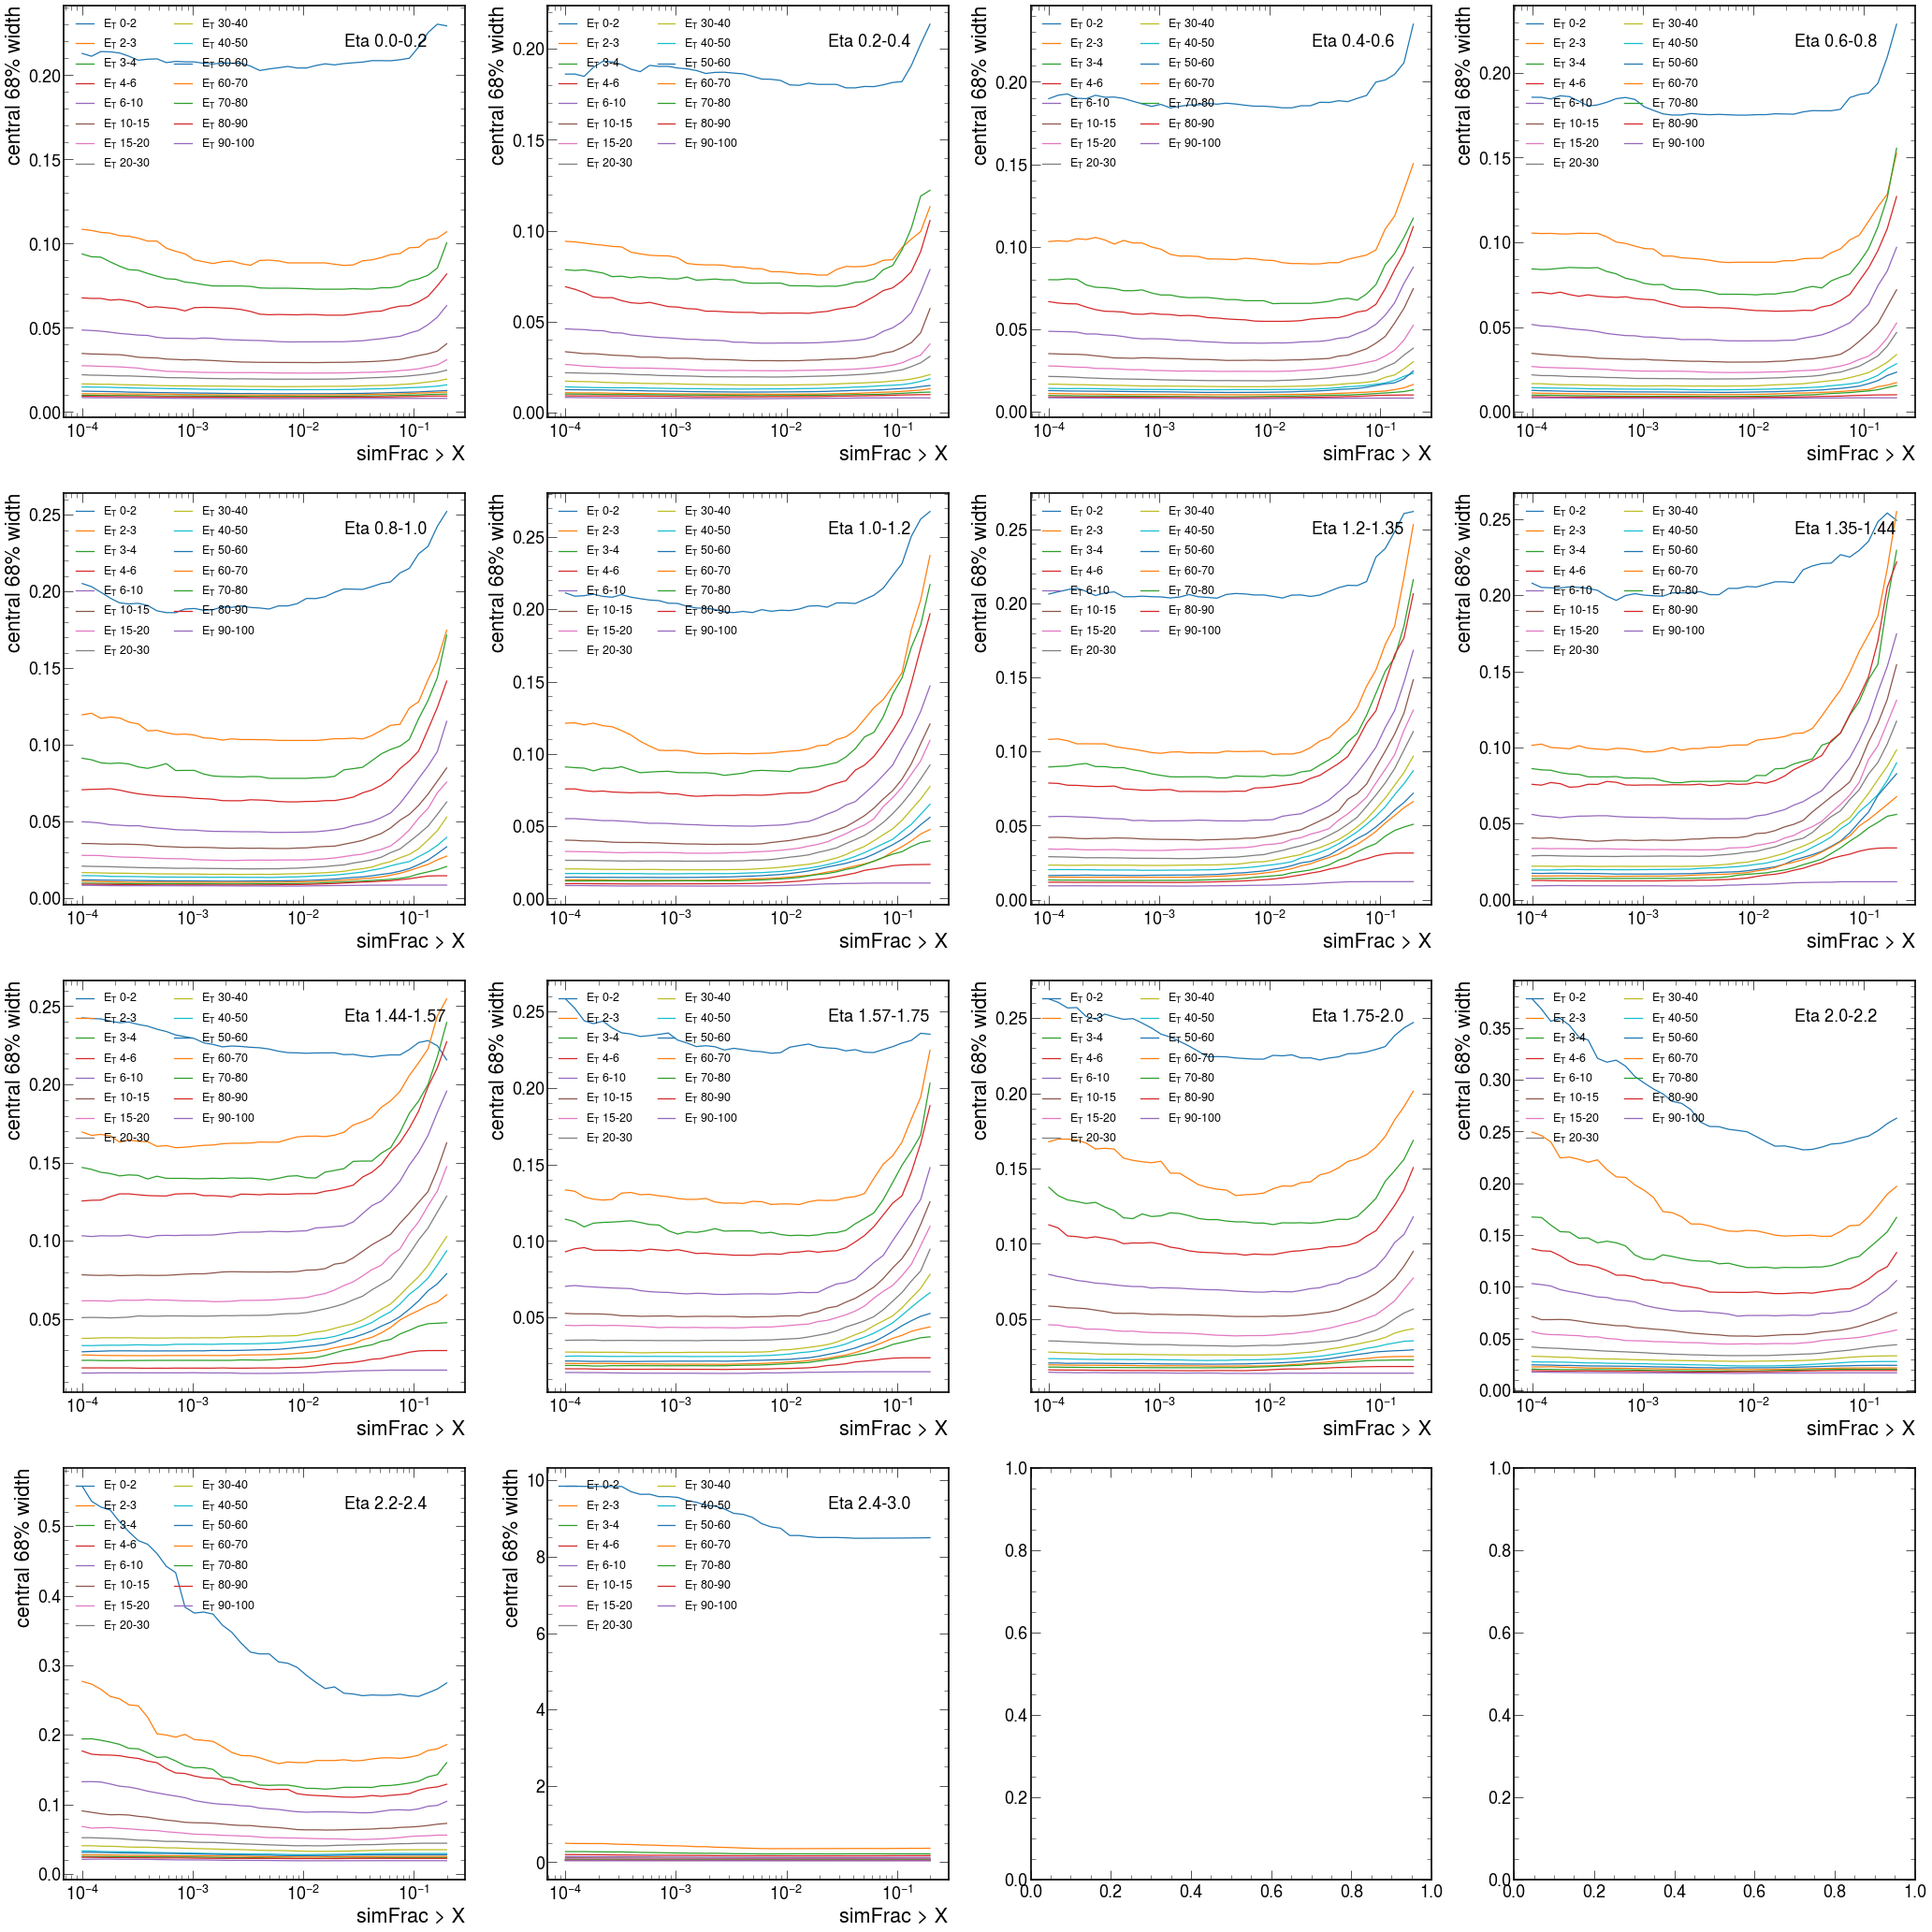

In [39]:
f, axs = plt.subplots(4,4, figsize=(35,35), dpi=60)

for i in range(len(etas)-1):   
    ax = axs[i//4][i% 4]
    for y in range(len(ets)-1):
        a = res[(res.eta_bin == i) & (res.et_bin==y)]
        ax.plot(a.thr, a.EoEtrue_68width, label='$E_T$ {}-{}'.format(ets[y], ets[y+1]))
        
    ax.text(0.7,0.9, "Eta {}-{}".format(etas[i],etas[i+1]),fontsize="small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='upper left', ncol=2)
    ax.set_ylabel("central 68% width")
    ax.set_xlabel("simFrac > X")
#     ax.set_xlim(0.01, 1000)
    ax.set_xscale("log")

f.tight_layout()
f.savefig(outputdir+'/Width_all.png')
f.savefig(outputdir+'/Width_all.pdf')

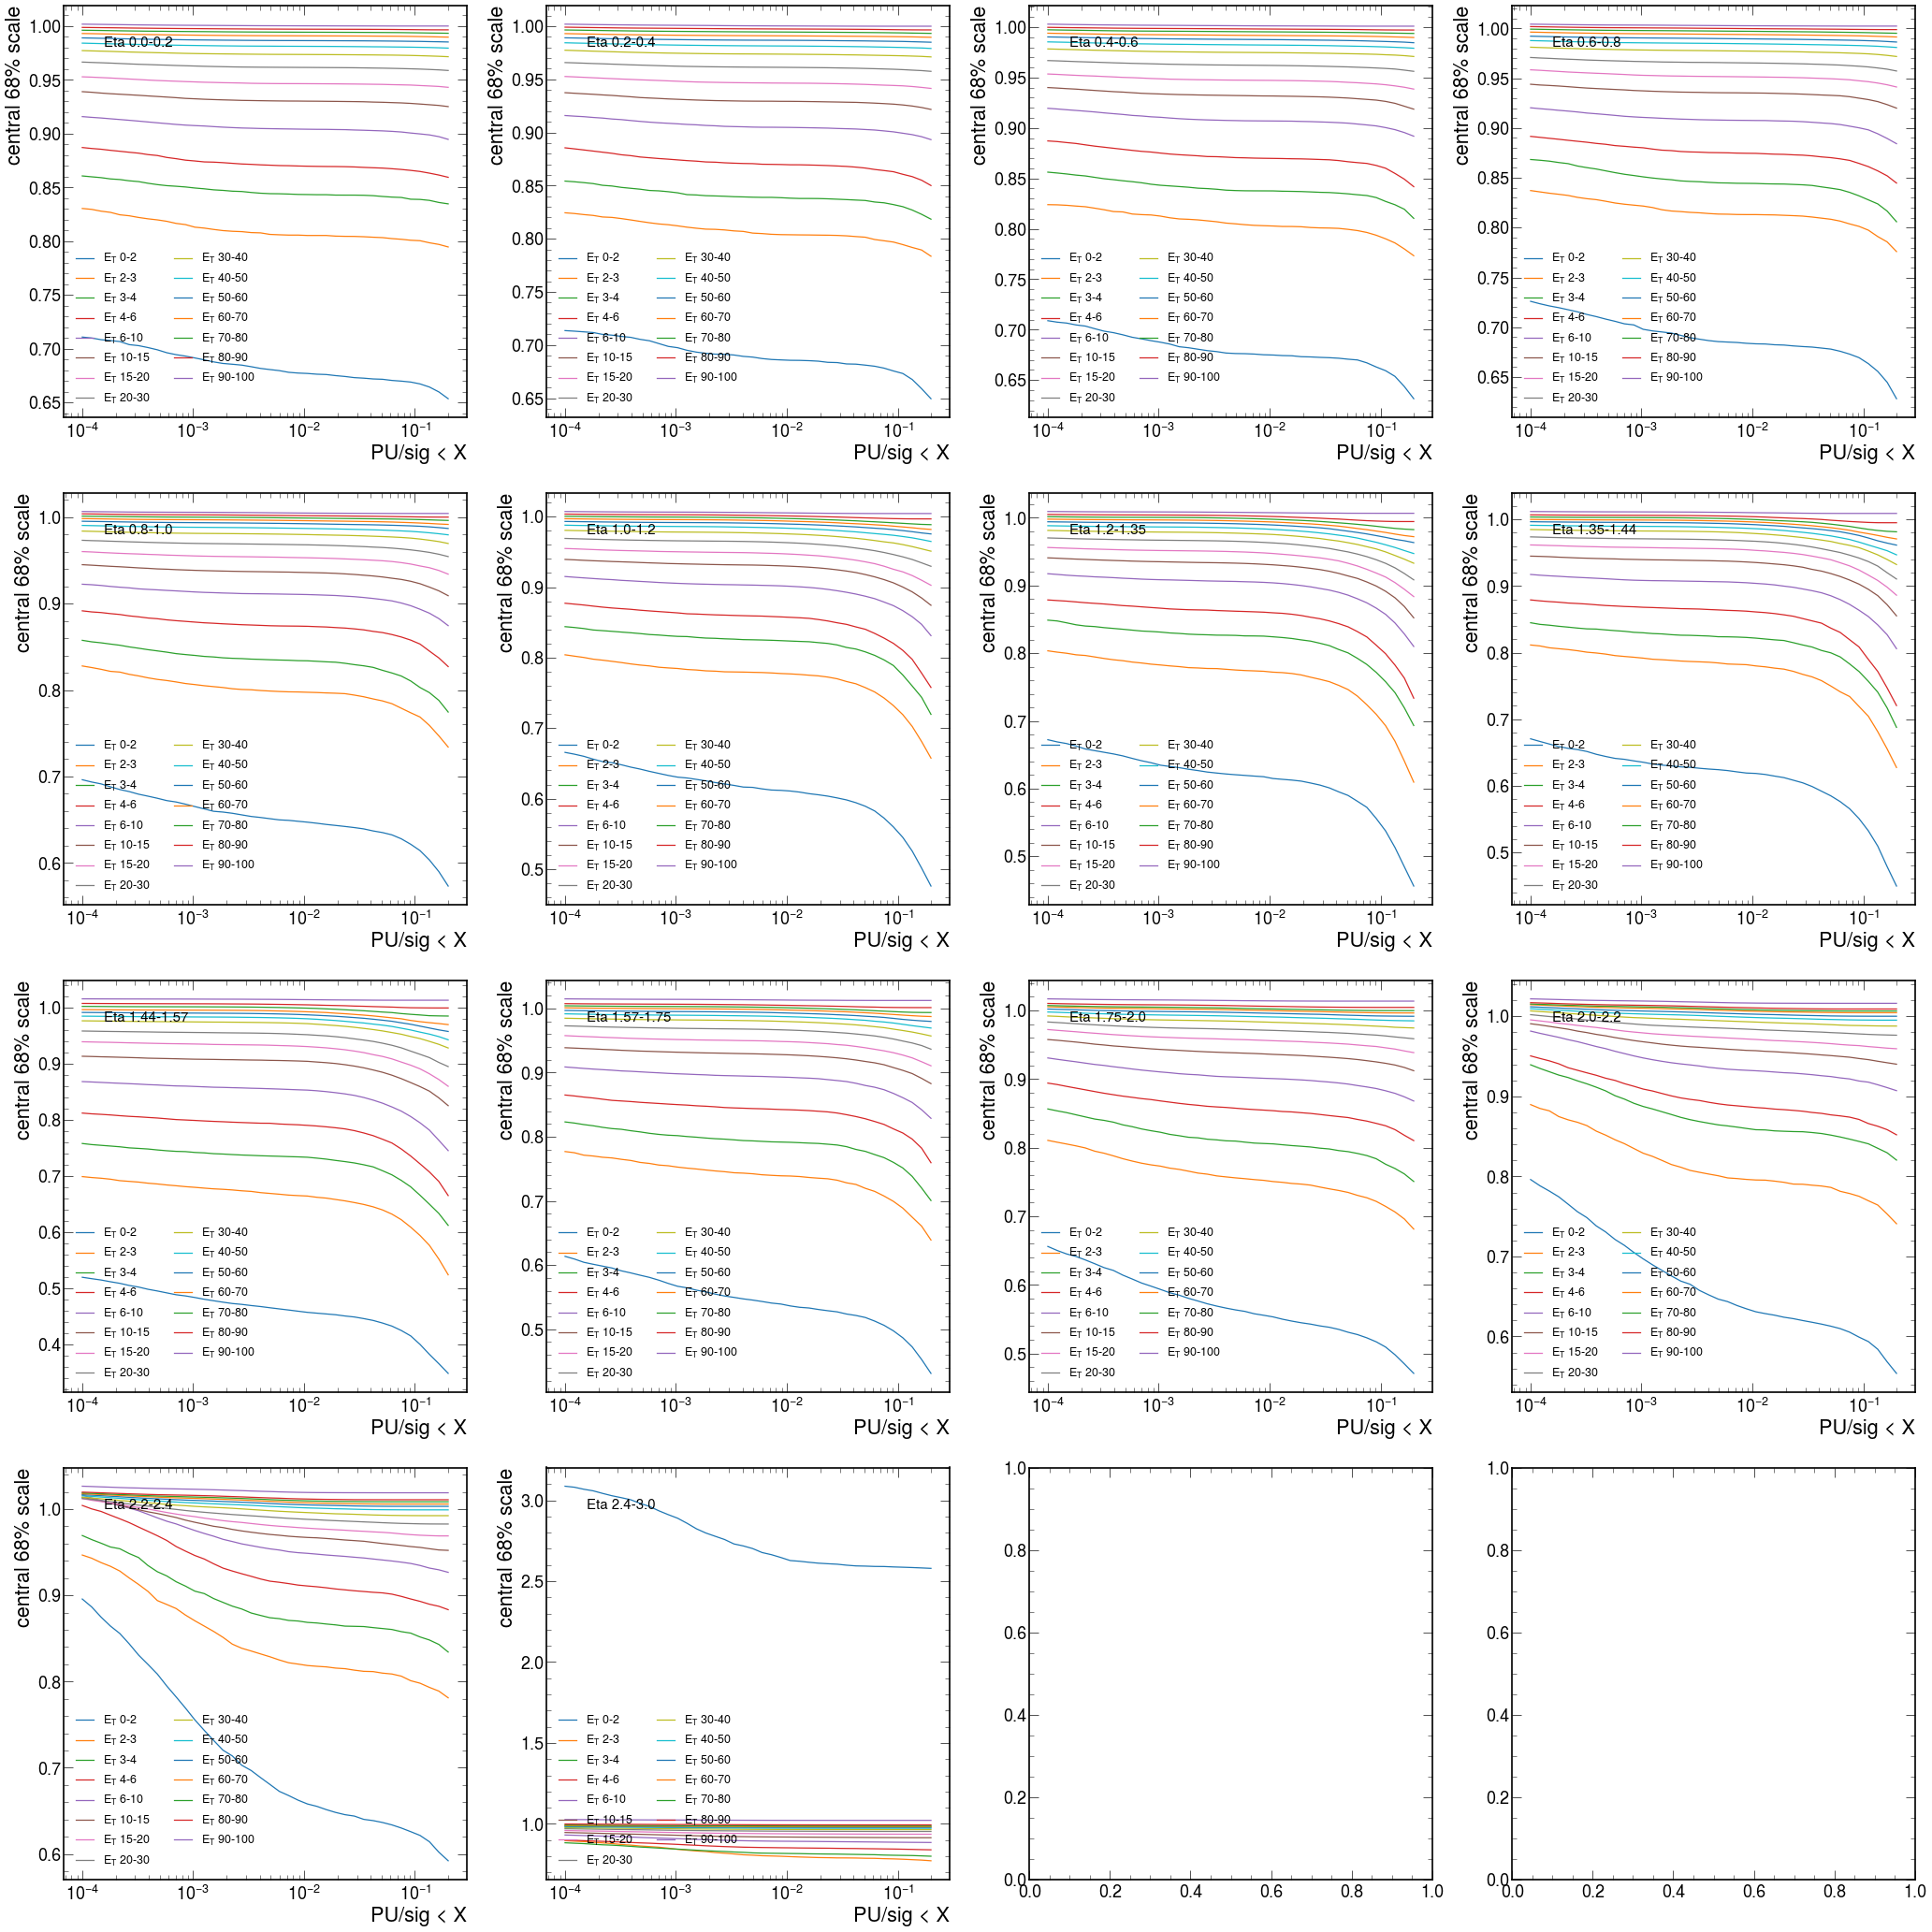

In [11]:
f, axs = plt.subplots(4,4, figsize=(35,35), dpi=60)

for i in range(len(etas)-1):   
    ax = axs[i//4][i% 4]
    for y in range(len(ets)-1):
        a = res[(res.eta_bin == i) & (res.et_bin==y)]
        ax.plot(a.thr, a.EoEtrue_68scale, label='$E_T$ {}-{}'.format(ets[y], ets[y+1]))
        
    ax.text(0.1,0.9, "Eta {}-{}".format(etas[i],etas[i+1]),fontsize="x-small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='lower left', ncol=2)
    ax.set_ylabel("central 68% scale")
    ax.set_xlabel("PU/sig < X")
#     ax.set_xlim(0.001, 0.05)
    ax.set_xscale("log")

f.tight_layout()
f.savefig(outputdir+'/Scale_all.png')

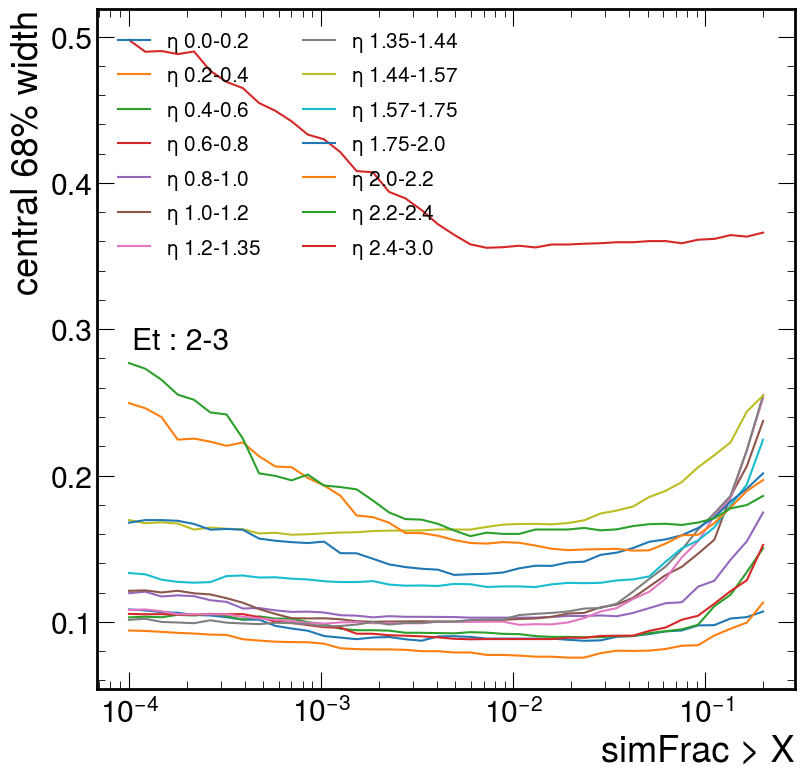

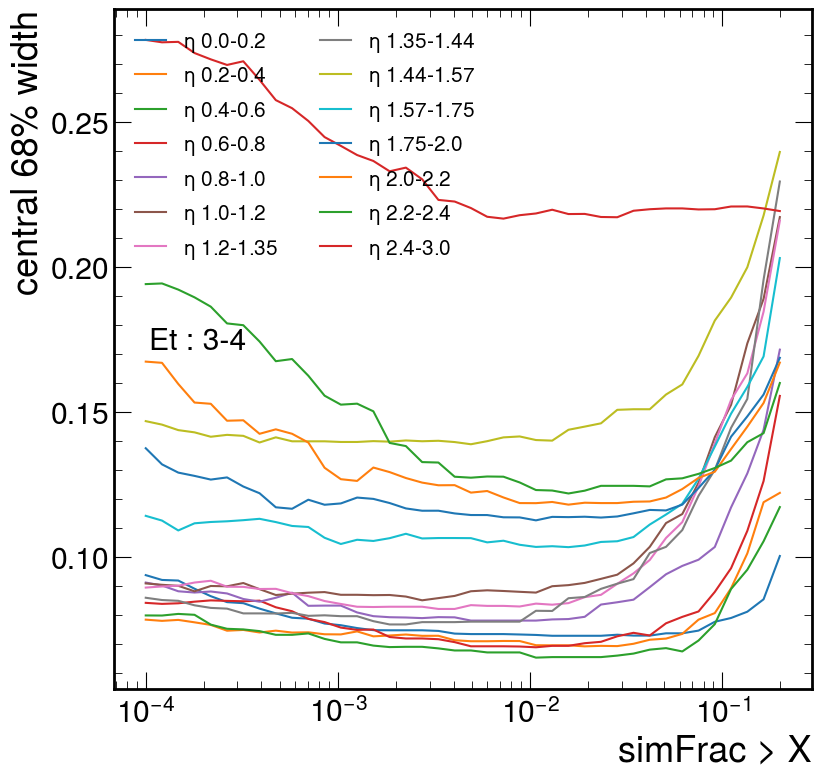

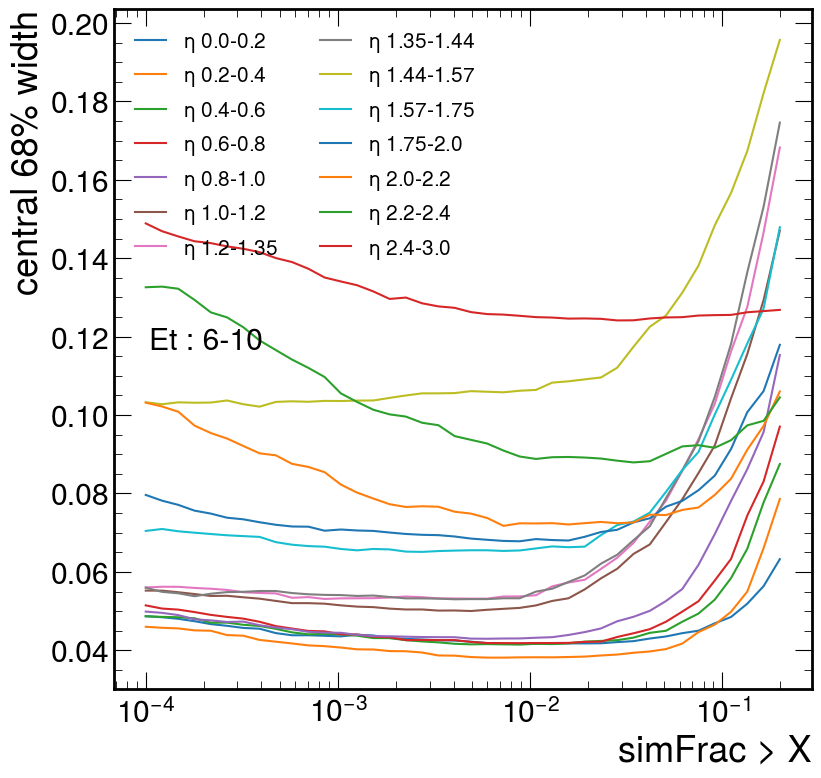

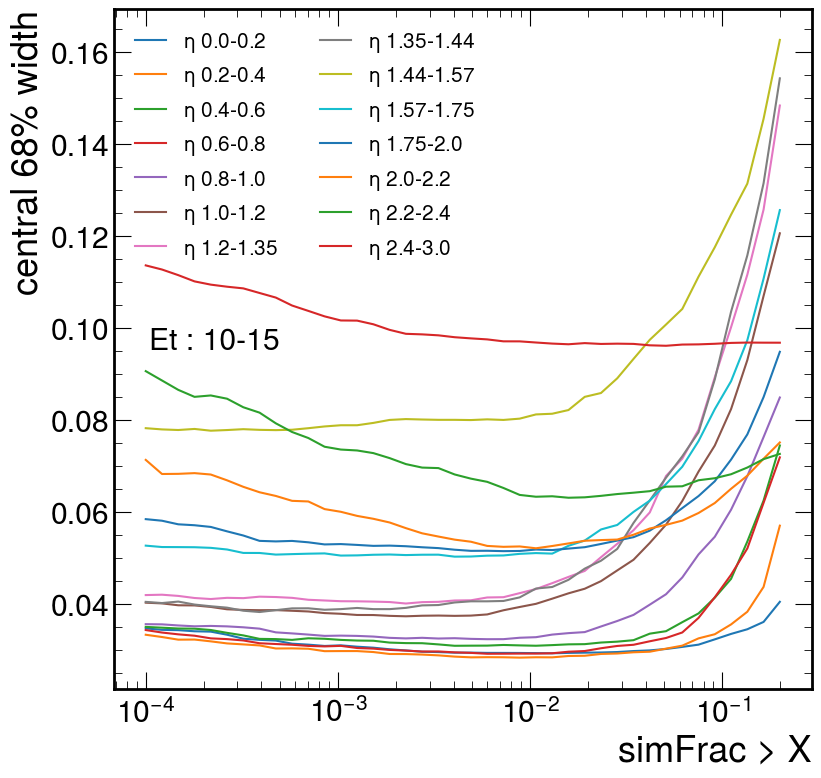

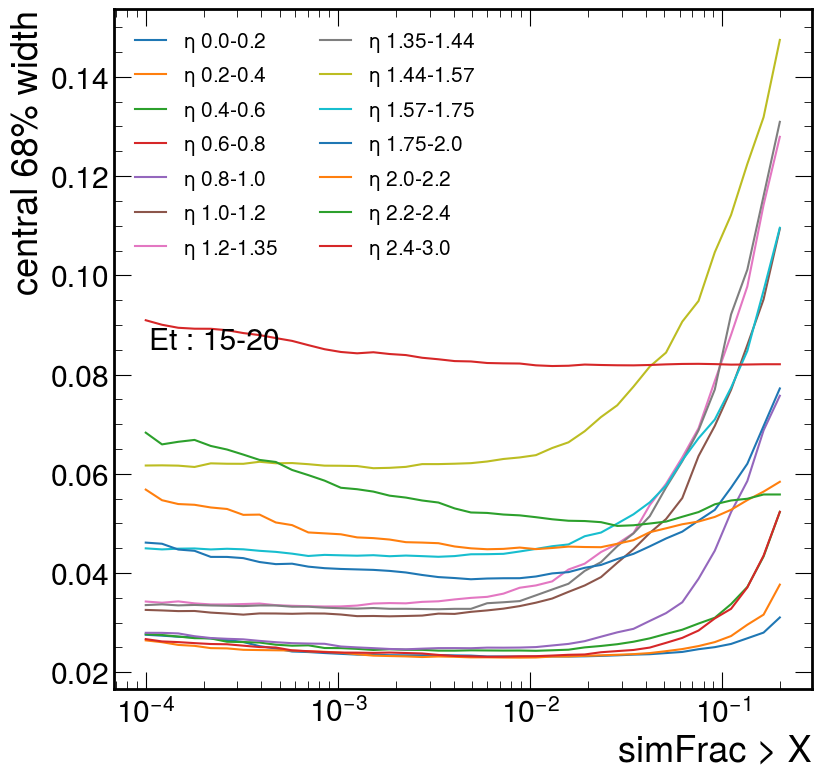

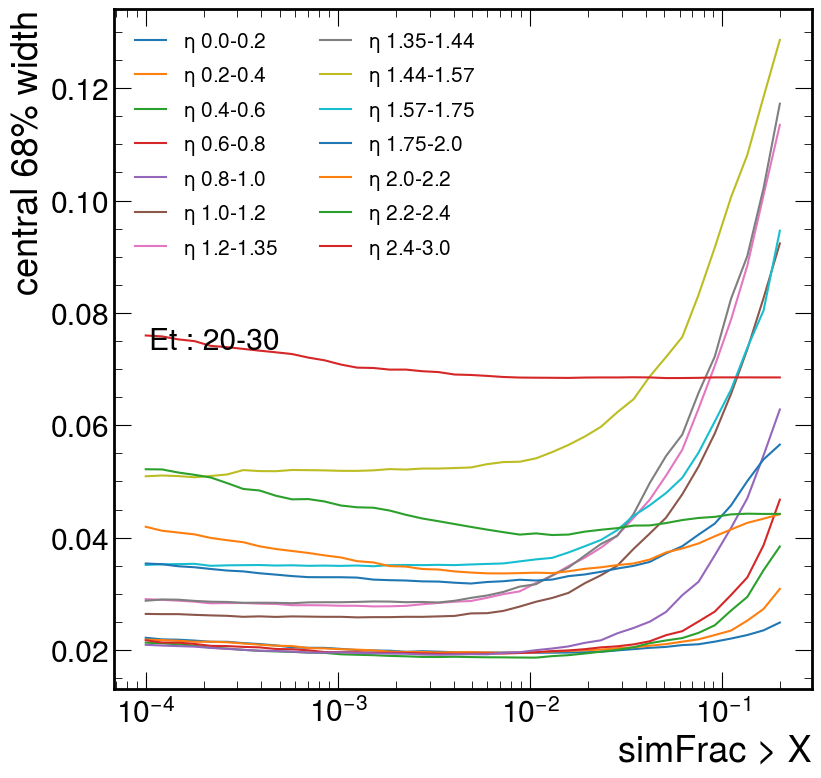

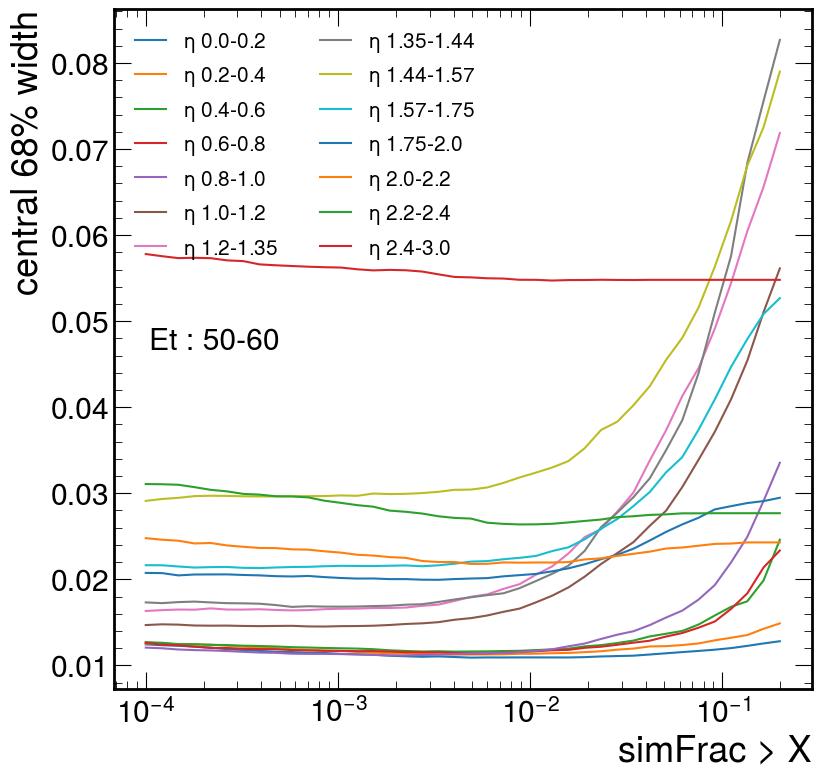

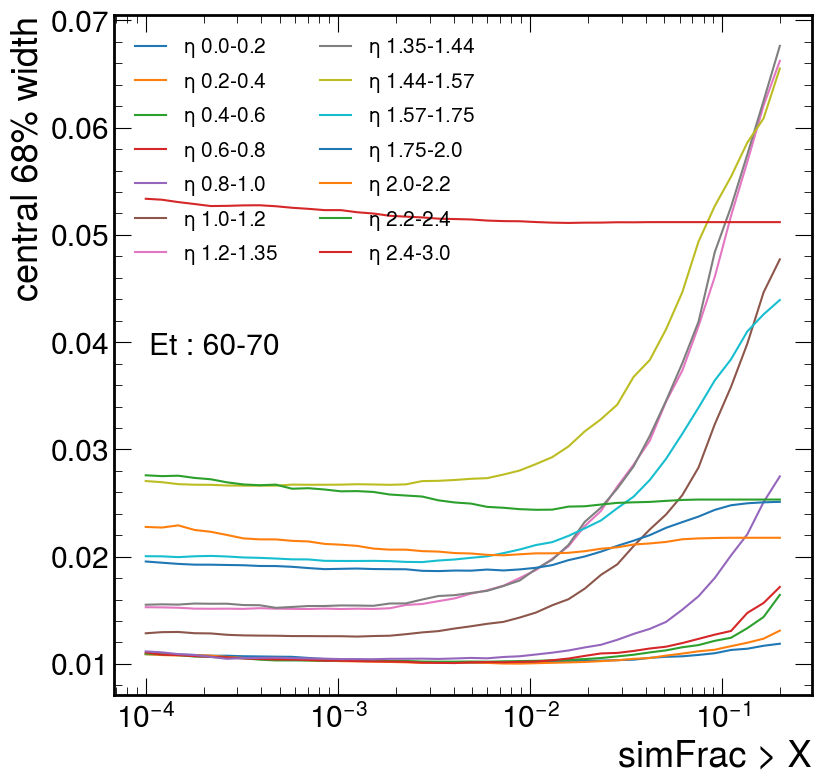

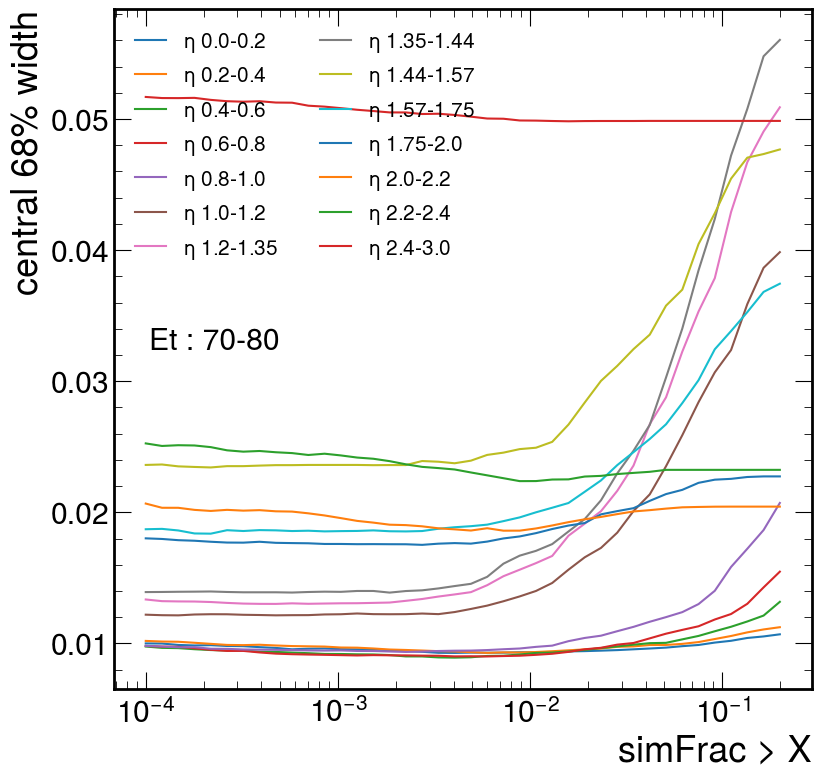

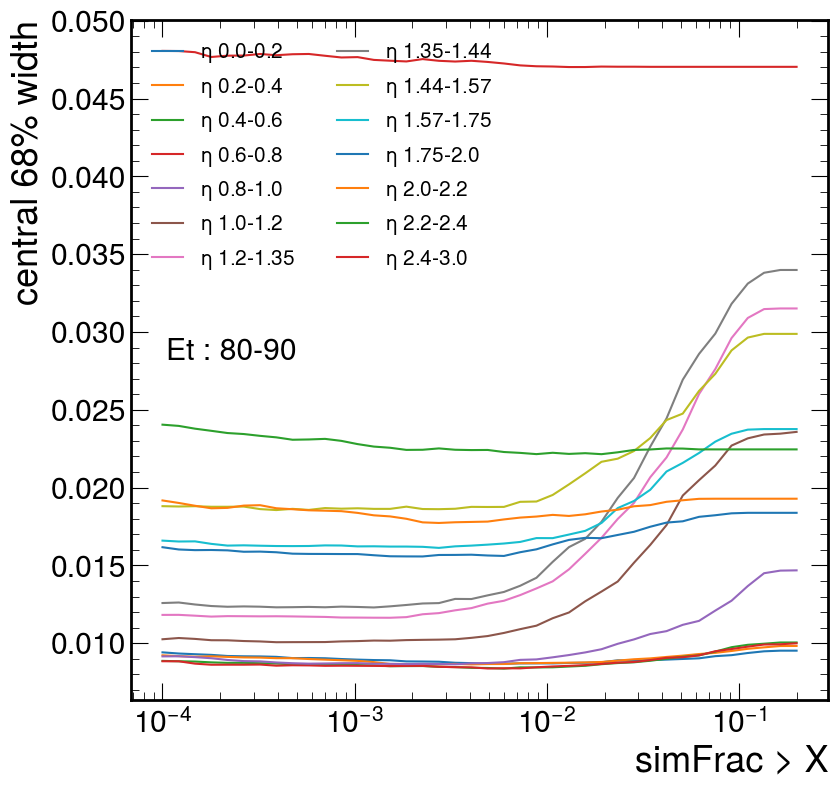

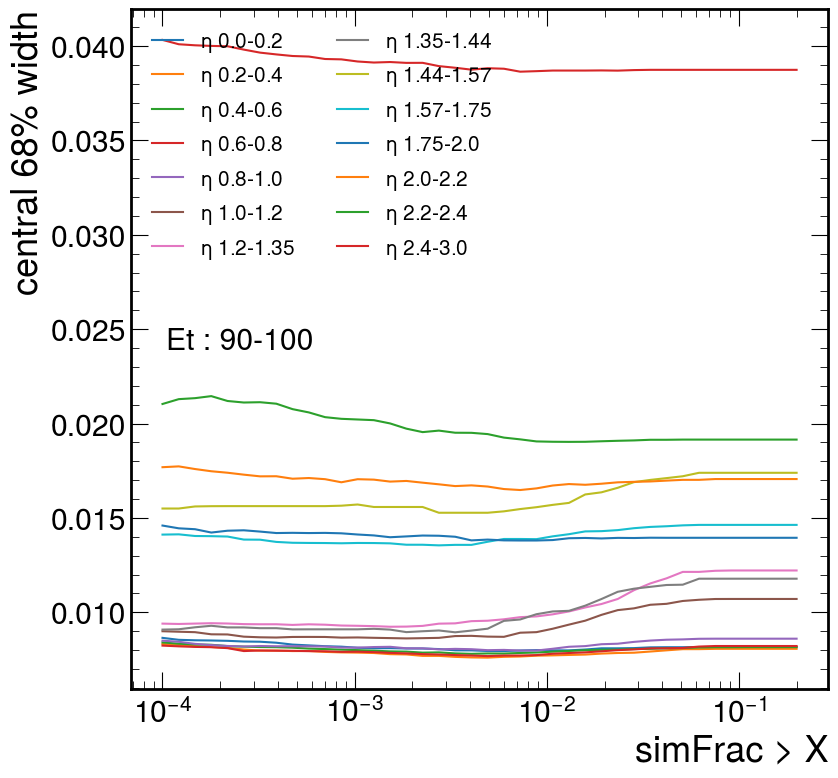

In [40]:
for iet in range(len(ets)-1):
    f, ax = plt.subplots(1,1, figsize=(9,9), dpi=100)

    for i in range(len(etas)-1): 
        a = res[(res.eta_bin == i) & (res.et_bin==iet)]
        ax.plot(a.thr, a.EoEtrue_68width, label='$\eta$ {}-{}'.format(etas[i], etas[i+1]))

    ax.text(0.05,0.5, "Et : {}-{}".format(ets[iet],ets[iet+1]),fontsize="small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='upper left', ncol=2)
    ax.set_ylabel("central 68% width")
    ax.set_xlabel("simFrac > X")
    #     ax.set_xlim(0.01, 1000)
    ax.set_xscale("log")

    f.savefig(outputdir+'/Width_Et{}_{}.png'.format(ets[iet],ets[iet+1]))
    f.savefig(outputdir+'/Width_Et{}_{}.pdf'.format(ets[iet],ets[iet+1]))

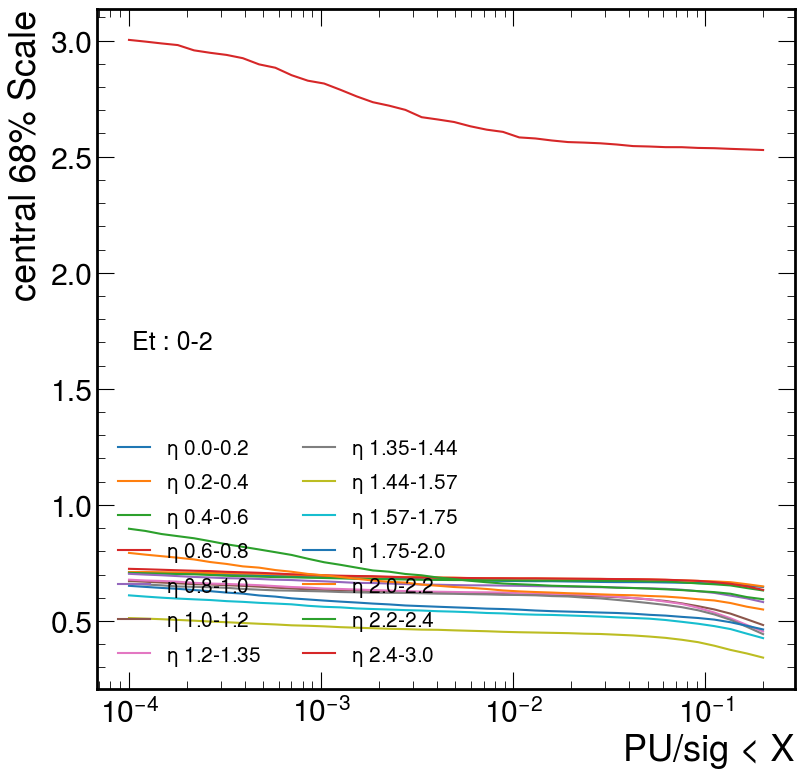

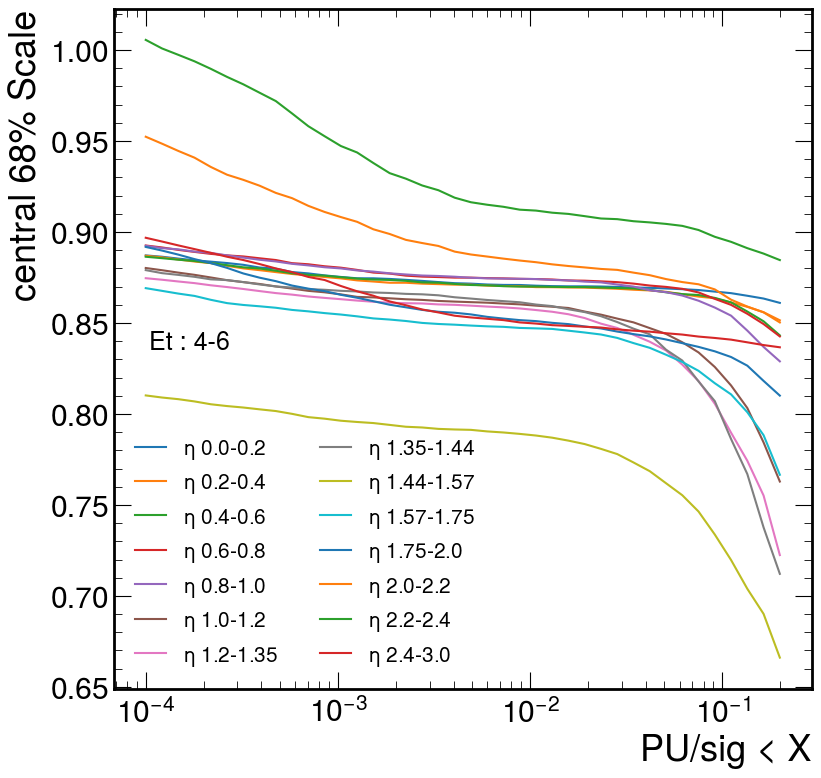

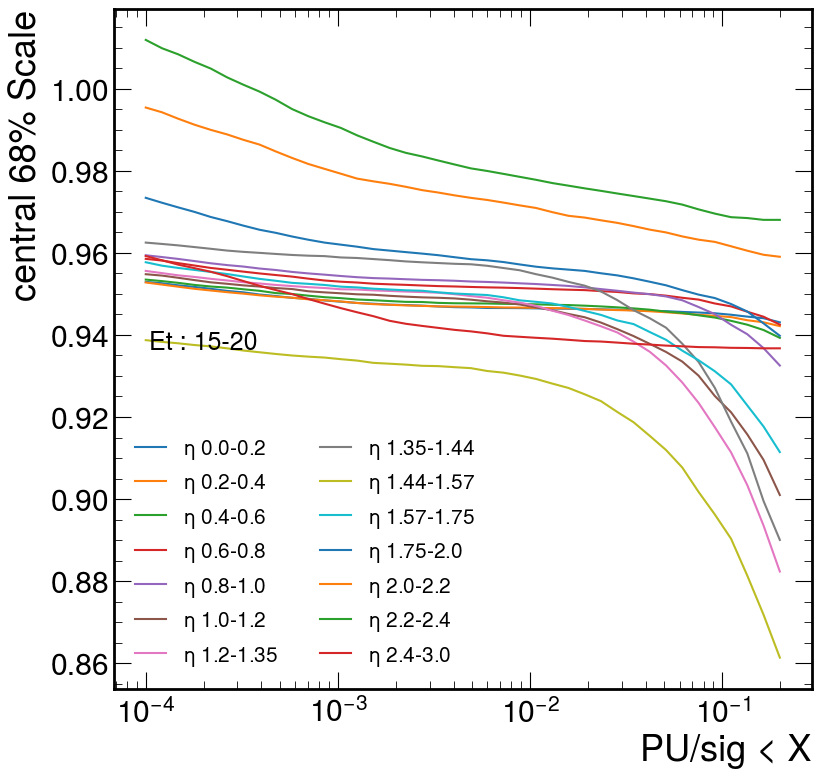

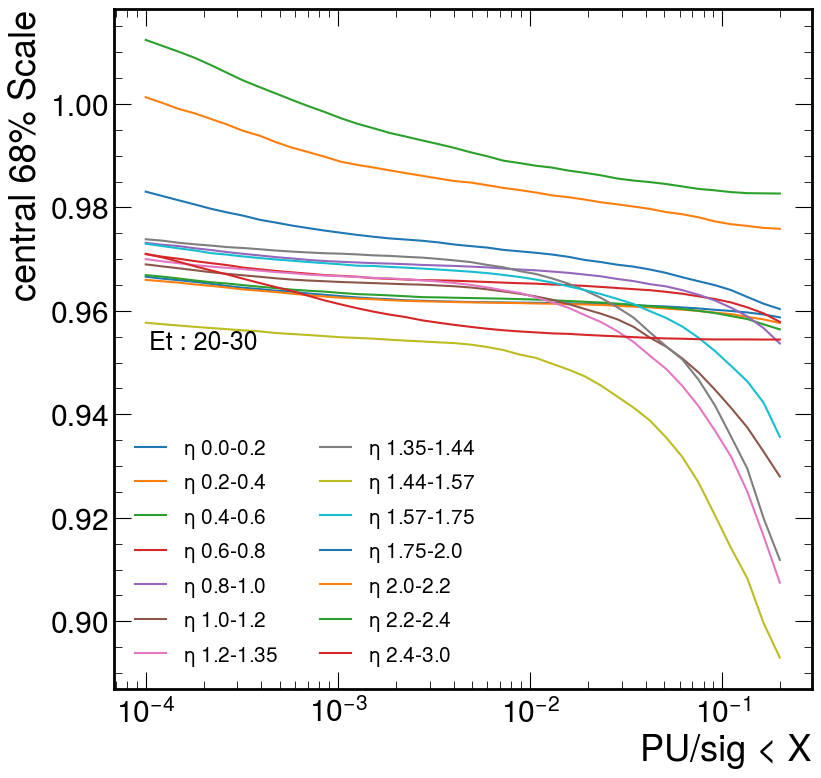

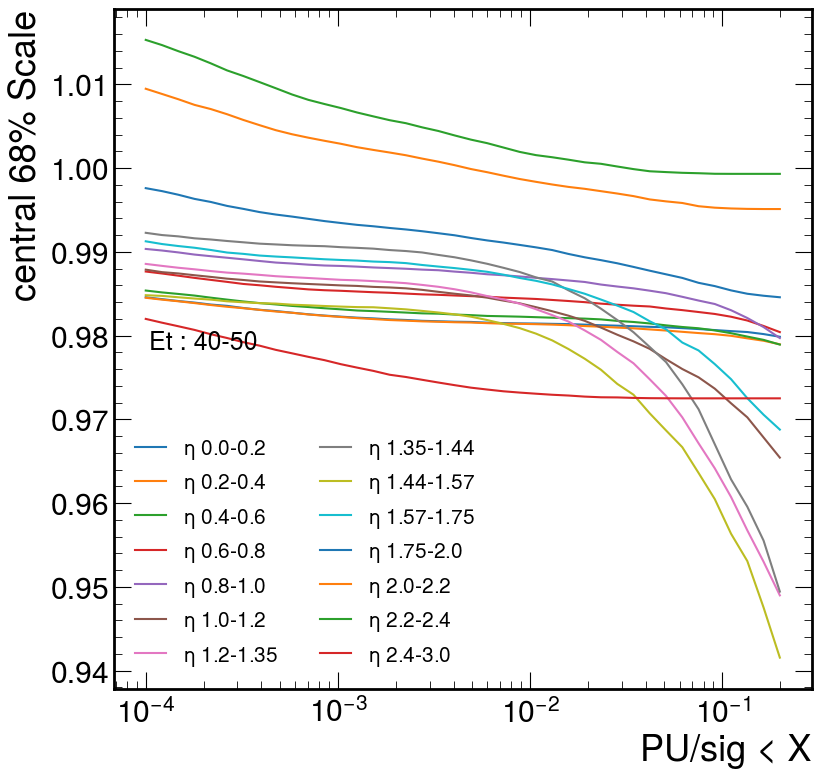

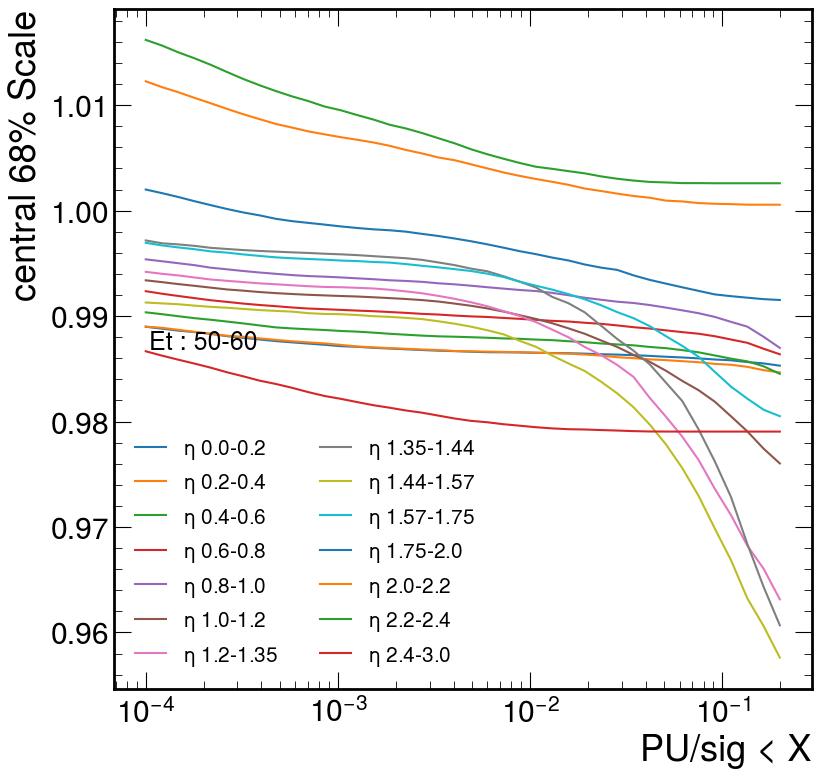

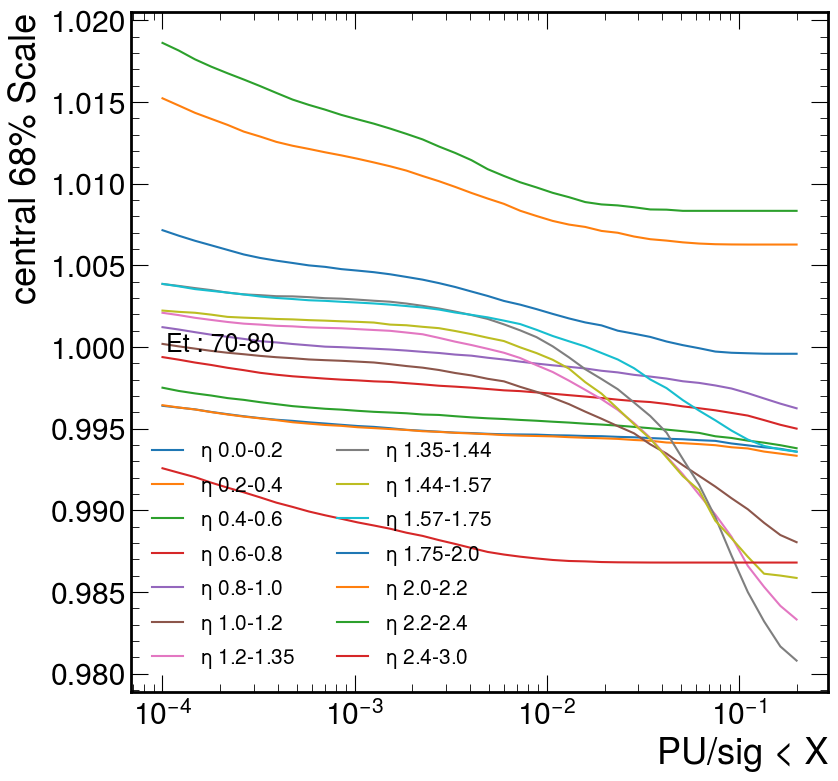

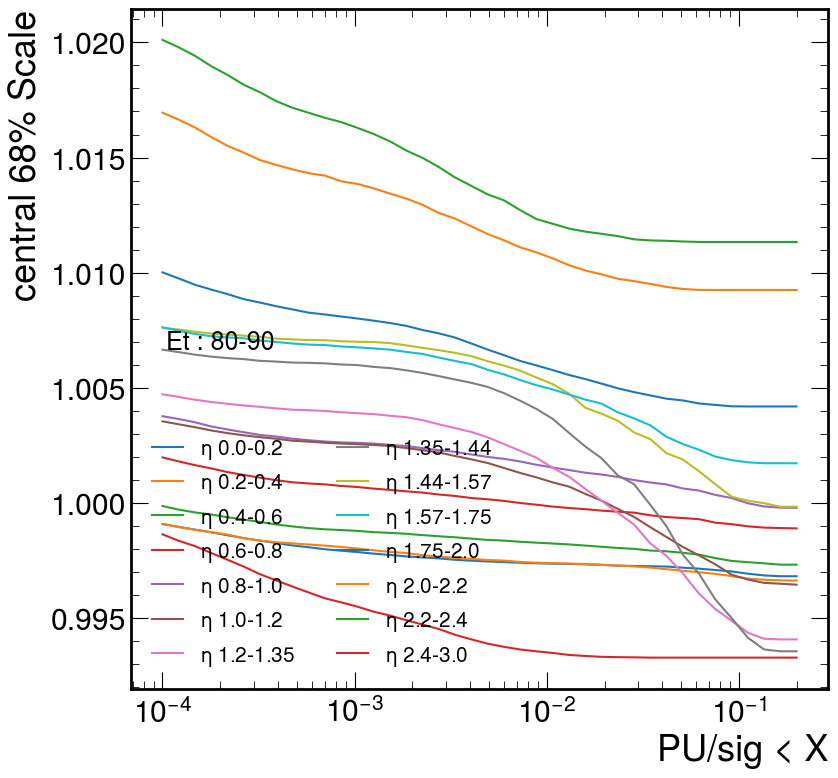

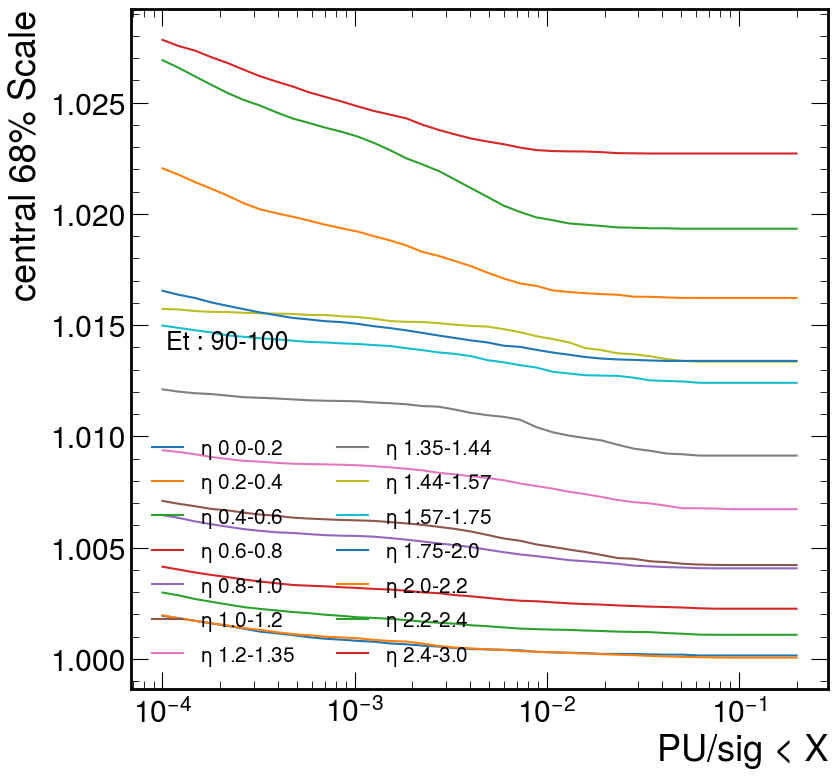

In [41]:
for iet in range(len(ets)-1):
    f, ax = plt.subplots(1,1, figsize=(9,9), dpi=100)

    for i in range(len(etas)-1): 
        a = res[(res.eta_bin == i) & (res.et_bin==iet)]
        ax.plot(a.thr, a.EoEtrue_68scale, label='$\eta$ {}-{}'.format(etas[i], etas[i+1]))

    ax.text(0.05,0.5, "Et : {}-{}".format(ets[iet],ets[iet+1]),fontsize="x-small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='lower left', ncol=2)
    ax.set_ylabel("central 68% Scale")
    ax.set_xlabel("PU/sig < X")
    #     ax.set_xlim(0.01, 1000)
    ax.set_xscale("log")

    f.savefig(outputdir+'/Scale_{}_{}.png'.format(ets[iet],ets[iet+1]))
    f.savefig(outputdir+'/Scale_{}_{}.pdf'.format(ets[iet],ets[iet+1]))

# Summary

In [37]:
def bin_analysis_summary(df):
    line = df.iloc[df["EoEtrue_68width"].argmin()]
    return pd.Series({
        "thr": line['thr'],
        "scale": line["EoEtrue_68width"],
        "width": line["EoEtrue_68width"],
        "rel_err" : line["rel_err"]
    })

a = res.groupby(['et_bin','eta_bin']).apply(bin_analysis_summary)
a.reset_index(level=0, inplace=True)
a.reset_index(level=0, inplace=True)

In [28]:
f, ax = plt.subplots(1,1, figsize=(9,9), dpi=100)

for i in range(len(etas)-1): 
    b = a[a.eta_bin == i]
    ax.plot(b.et_bin, b.thr, label='$\eta$ {}-{}'.format(etas[i], etas[i+1]), marker="o")

ax.legend(fontsize="xx-small", loc='upper right', ncol=2)
ax.set_ylabel("SimFrac threshold")
ax.set_xlabel("$E_T$ GeV")
ax.set_ylim(1e-4, 10)
ax.set_yscale("log")
ax.set_xticks(list(range(len(ets)-1)))
ax.set_xticklabels(["{}".format(et) for et in ets[1:]])

f.savefig(outputdir+'/Scale_all.png')

/tmp/ipykernel_513/2641805073.py:3: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.imshow(c.T, cmap="plasma", norm=colors.LogNorm(), origin="lower", vmin=1e-4)


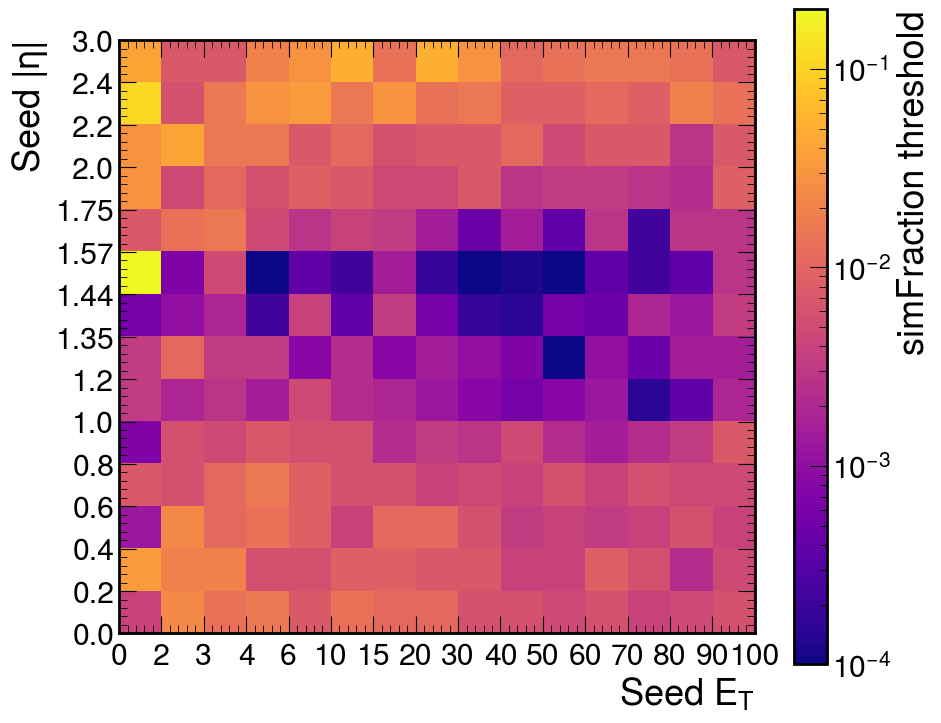

In [38]:
f = plt.figure(figsize=(10,8), dpi=100)
c = a.thr.values.reshape((len(ets)-1, len(etas)-1))
plt.imshow(c.T, cmap="plasma", norm=colors.LogNorm(), origin="lower", vmin=1e-4)
plt.colorbar(label="simFraction threshold")
plt.xlabel("Seed $E_T$")
plt.ylabel("Seed $|\eta|$")
plt.xticks(np.arange(len(ets))-0.5, [ "{}".format(e) for e in ets])
plt.yticks(np.arange(len(etas))-0.5, [ "{}".format(e) for e in etas])
f.tight_layout()
f.savefig(outputdir+ "/simfraction_map.png")
f.savefig(outputdir+ "/simfraction_map.pdf")

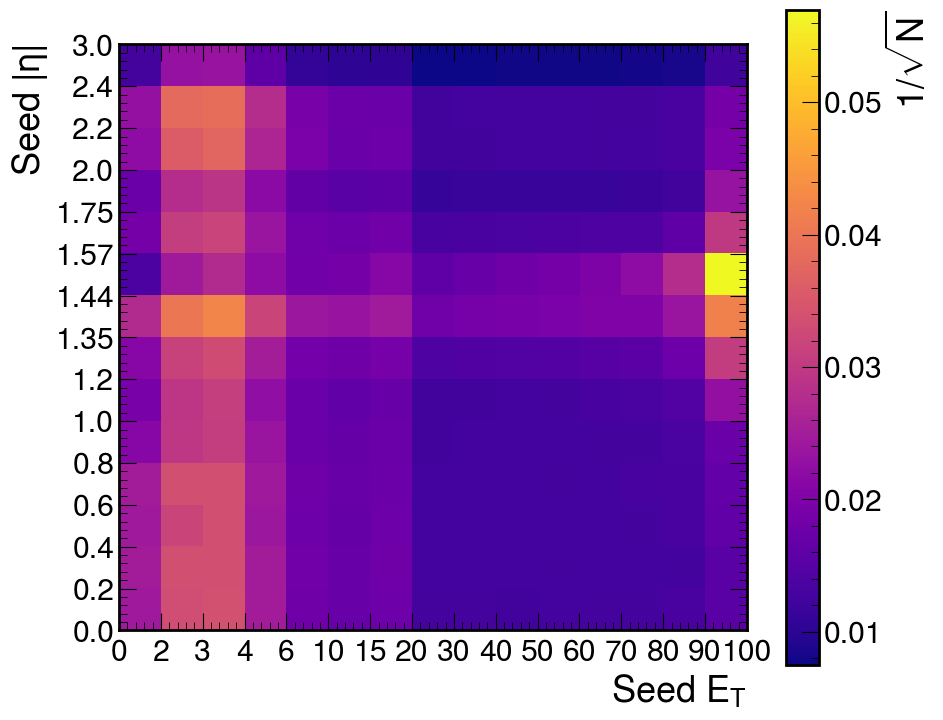

In [15]:
f = plt.figure(figsize=(10,8), dpi=100)
c = a.rel_err.values.reshape((len(ets)-1, len(etas)-1))
plt.imshow(c.T, cmap="plasma", origin="lower")
plt.colorbar(label="$1 / \sqrt{N}$")
plt.xlabel("Seed $E_T$")
plt.ylabel("Seed $|\eta|$")
plt.xticks(np.arange(len(ets))-0.5, [ "{}".format(e) for e in ets])
plt.yticks(np.arange(len(etas))-0.5, [ "{}".format(e) for e in etas])
f.tight_layout()
f.savefig(outputdir+ "/simfraction_map_relerr.png")

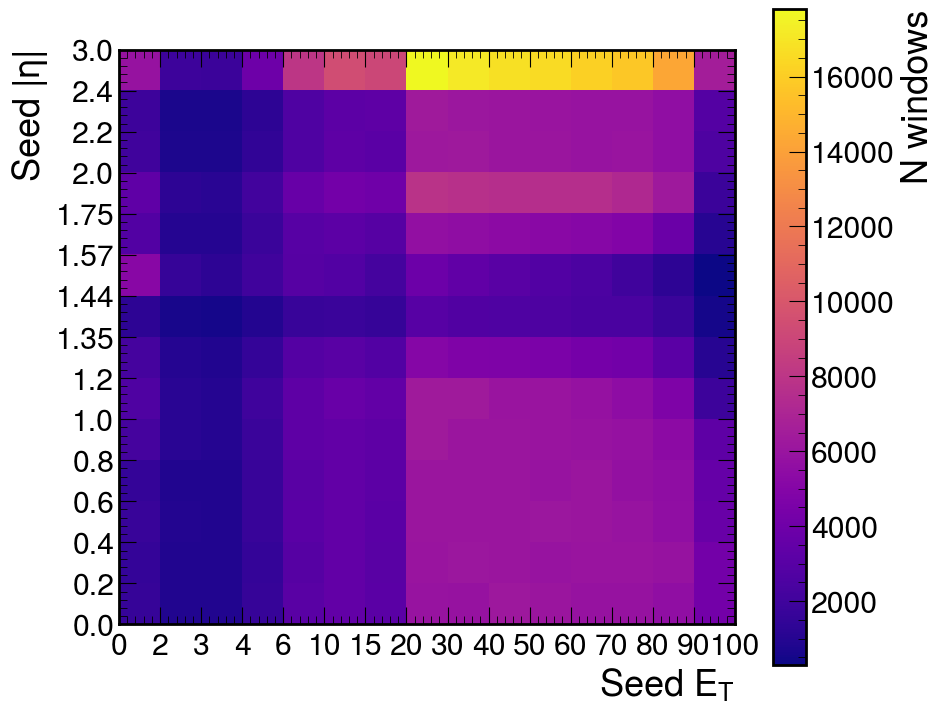

In [16]:
f = plt.figure(figsize=(10,8), dpi=100)
c = np.square((1/ a.rel_err).values).reshape((len(ets)-1, len(etas)-1))
plt.imshow(c.T, cmap="plasma", origin="lower")
plt.colorbar(label="N windows")
plt.xlabel("Seed $E_T$")
plt.ylabel("Seed $|\eta|$")
plt.xticks(np.arange(len(ets))-0.5, [ "{}".format(e) for e in ets])
plt.yticks(np.arange(len(etas))-0.5, [ "{}".format(e) for e in etas])
f.tight_layout()
f.savefig(outputdir+ "/simfraction_map_Nwindows.png")

# Save histogram

In [17]:
import ROOT as R
from array import array

Welcome to JupyROOT 6.24/00


In [18]:
h2 = R.TH2F("h2_Minimum_simScore_seedBins", "thr", len(ets)-1, array("d", ets), len(etas)-1, array("d", etas))

In [19]:
for _, row in a.iterrows():
    h2.SetBinContent(h2.FindBin(ets[int(row.et_bin)], etas[int(row.eta_bin)]), row.thr)

In [20]:
c = R.TCanvas()
h2.Draw("COLZ")
c.SetLogz()
c.Draw()

In [21]:
out = R.TFile("simScore_ele.root","RECREATE")
h2.Write()
out.Close()